In [28]:
#install.packages('ggpubr', repos = 'https://cloud.r-project.org')


Installing package into ‘/Users/kevin_cunningham/Library/R/arm64/4.5/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’





The downloaded binary packages are in
	/var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//RtmpO7m1gh/downloaded_packages


In [37]:
library("ggplot2")
library("dplyr")
library("scales")
library("RColorBrewer")
library("ggpubr")
#defined samples to include
sample_names_df = c("DW01","DW02","DW03","DW04","DW05","DW06","DW07","DW08","DW09","DW10",
                    "DW11","DW12","DW13","DW14","DW15","DW16","DW17","DW18","DW19","DW20",
                    "DW21","DW22","DW23","DW24","DW25","DW26","DW27","DW28","DW29","DW30",
                           "DW32","DW33","DW34","DW35","DW36","DW37","DW38","DW39","DW40",
                    "DW41","DW42","DW43","DW44","DW45","DW46","DW47","DW48","DW49","DW50",
                    "DW51","DW52","DW53","DW54","DW55","DW56","DW57","DW58","DW59")

default_table_names = c("Segment","Voxel count (LM)", "Volume mm3 (LM)", "Volume cm3 (LM)", "Voxel count (SV)", "Volume mm3 (SV)","Volume cm3 (SV)","Minimum", "Maximum", "Mean", "Standard deviation",
                        "Percentile 5", "Percentile 95", "Median", "Surface mm2", "Volume mm3 (CS)", "Volume cm3 (CS)")
#read in the samples details
sample_info_df = read.csv("uCT scan records.csv")

#sample_info_df
sampleID_df = data.frame(sample_info_df$Sample.name..scanco.)
colnames(sampleID_df) = "SampleID"
sampleID_duration_df = data.frame(factor(sample_info_df$exp_endpoint..days.))
colnames(sampleID_duration_df) = "Endpoint_days"
sampleID_and_duration_df = data.frame(cbind(sampleID_df, sampleID_duration_df))
#sampleID_and_duration_df

#make a dataframe for all bone statistics
num_samples = length(sample_names_df)
all_bone_samples_df = data.frame(matrix(data = 0, nrow = num_samples, ncol = 19))
data_names = c("SampleID","Orientation side","Segment", "Voxel count (LM)","Volume mm3 (LM)" , "Volume cm3 (LM)", "Voxel count (SV)","Volume mm3 (SV)","Volume cm3 (SV)",
                          "Orientation side","Segment", "Voxel count (LM)","Volume mm3 (LM)" , "Volume cm3 (LM)", "Voxel count (SV)","Volume mm3 (SV)","Volume cm3 (SV)", 
               "Difference_in_volume", "Total_volume")
colnames(all_bone_samples_df) = data_names
#head(all_bone_samples_df)
#Segment	Voxel count (LM)	Volume mm3 (LM)	Volume cm3 (LM)	Voxel count (SV)	Volume mm3 (SV)	Volume cm3 (SV)
i = 1
for(i in 1:num_samples){
  #read in the left side table
  current_sample_name = sample_names_df[i]
  left_table_file = current_sample_name
  left_table_file = paste0(left_table_file, "/")
  left_table_file = paste0(left_table_file, current_sample_name)
  left_table_file = paste0(left_table_file,"_L.tsv")
  #print(left_table_file)
  current_sample_Left_df = read.table(file = left_table_file, header = TRUE, fill = TRUE)
  colnames(current_sample_Left_df) = default_table_names
  current_sample_Left_df = current_sample_Left_df[1:2,1:17]
  #current_sample_Left_df
  
  # #read in the right side table
  right_table_file = current_sample_name
  right_table_file = paste0(right_table_file, "/")
  right_table_file = paste0(right_table_file, current_sample_name)
  right_table_file = paste0(right_table_file,"_R.tsv")
  #print(right_table_file)
  current_sample_Right_df = read.table(file = right_table_file, header = TRUE, fill = TRUE)
  colnames(current_sample_Right_df) = default_table_names
  current_sample_Right_df = current_sample_Right_df[1:2,1:17]
  #current_sample_Right_df
  
  
  # #gather the results for the left side
  all_bone_samples_df[i, 1] = sample_names_df[i]
  all_bone_samples_df[i, 2] = "Left"
  all_bone_samples_df[i, 3:9] = current_sample_Left_df[2, 1:7]

  all_bone_samples_df[i, 10] = "Right"
  all_bone_samples_df[i, 11:17] = current_sample_Right_df[2, 1:7]
  all_bone_samples_df[i, 18] = all_bone_samples_df[i, 6] - all_bone_samples_df[i, 14]
  all_bone_samples_df[i, 19] = all_bone_samples_df[i, 6] + all_bone_samples_df[i, 14]

}
#all_bone_samples_df

#gather only the sampleID and the differences
bone_sample_IDS = all_bone_samples_df$SampleID
#bone_sample_IDS
bone_differences = as.numeric(all_bone_samples_df$Difference_in_volume)
#bone_differences
bone_data_to_plot = data.frame(cbind(bone_sample_IDS,bone_differences))
colnames(bone_data_to_plot) = cbind("SampleID","Difference_in_volume")
#bone_data_to_plot
bone_data_to_plot2 = merge(bone_data_to_plot, sampleID_and_duration_df, by = "SampleID", all.x = TRUE)
bone_data_to_plot2$Endpoint_days = as.character(bone_data_to_plot2$Endpoint_days)

#add the value 0
zero_value = data.frame(matrix(data = 0, nrow = 1, ncol = 3))
colnames(zero_value) = cbind("SampleID","Difference_in_volume","Endpoint_days")
zero_value[1,1] = "Empty value"
bone_data_to_plot2 = rbind(bone_data_to_plot2,zero_value)
#summary(as.numeric(bone_data_to_plot2[1:num_samples, 2]))
#move the scale from cm to microns, multiply by 1,000,000
bone_data_to_plot3 = bone_data_to_plot2
bone_data_to_plot3$Difference_in_volume = as.numeric(bone_data_to_plot3$Difference_in_volume) * 1000000
bone_data_to_plot3$Endpoint_days = factor(bone_data_to_plot3$Endpoint_days,
                                             levels = c("0", "0.166666667", "0.333333333", "0.666666667", "1", "2", "4", "8", "14", "28"))

scatter_of_bone_differences = ggplot(data = bone_data_to_plot3, aes(x = SampleID, y = Difference_in_volume, color = Endpoint_days)) + 
                              geom_point() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
                              scale_y_continuous(breaks = seq(-250, 250, by = 25)) + ylab("Difference in bone Volume (Left - Right) microns") +
                              ggtitle("Difference in Bone Volume")
# Step 1: Call the pdf command to start the plot
pdf(file = "Differences_in_bone_volume.pdf",   # The directory you want to save the file in
    width = 12, # The width of the plot in inches
    height = 12) # The height of the plot in inches
# Step 2: Create the plot with R code
print(scatter_of_bone_differences)
# Step 3: Run dev.off() to create the file!
dev.off()








agg_record_2142411892 
                    2

In [43]:
#plot the total volume for the left and right side
bone_total_volume = as.numeric(all_bone_samples_df$Total_volume)
bone_volume_to_plot = data.frame(cbind(bone_sample_IDS,bone_total_volume))
colnames(bone_volume_to_plot) = cbind("SampleID","Total_volume")
#print(summary(as.numeric(bone_volume_to_plot$Total_volume)))

#add the ligand duration data
bone_volume_to_plot2 = merge(bone_volume_to_plot, sampleID_and_duration_df, by = "SampleID", all.x = TRUE)
bone_volume_to_plot2$Endpoint_days = as.character(bone_volume_to_plot2$Endpoint_days)
#add the value 0
# zero_sample_val = data.frame(matrix(data = 0, nrow = 1, ncol = 3))
# colnames(zero_sample_val) = c("SampleID", "Total_volume", "Endpoint_days")
# zero_sample_val[1,1] = "Empty_value"
# bone_volume_to_plot2 = rbind(bone_volume_to_plot2,zero_sample_val)

bone_volume_to_plot2$Total_volume = as.numeric(bone_volume_to_plot2$Total_volume)
#increase the units from cm to microns, multiple by 1,000,000
bone_volume_to_plot3 = bone_volume_to_plot2
bone_volume_to_plot3$Total_volume = bone_volume_to_plot3$Total_volume*1000000
bone_volume_to_plot3$Endpoint_days <- factor(
  as.character(bone_volume_to_plot3$Endpoint_days),
  levels = c("0","0.166666667", "0.333333333", "0.666666667","1", "2", "4", "8", "14", "28")
)

bone_volume_to_plot3 <- bone_volume_to_plot3[order(bone_volume_to_plot3$Endpoint_days,
                                                   bone_volume_to_plot3$Total_volume), ]

bone_volume_to_plot3$SampleID <- factor(
  bone_volume_to_plot3$SampleID,
  levels = bone_volume_to_plot3$SampleID
)


In [44]:
bargraph_of_bone_volume = ggplot(data = bone_volume_to_plot3, aes(x = SampleID, y = Total_volume, fill = Endpoint_days)) + 
                          geom_bar(stat = "identity",  position = position_stack(reverse = TRUE),color = "black") + theme_bw() + 
                          theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
                          ylab("Total Volume (microns cubed)") + scale_y_continuous(breaks = seq(0, 1375, by = 125)) +
                          ggtitle("Total Volume of Bones") + theme(axis.text.x = element_text(color = "black")) +
                          labs(fill = "Endpoint (days)") + scale_fill_brewer(palette = "Set3")

# Step 1: Call the pdf command to start the plot
pdf(file = "Total_bone_volume.pdf",   # The directory you want to save the file in
    width = 12, # The width of the plot in inches
    height = 12) # The height of the plot in inches
# Step 2: Create the plot with R code
print(bargraph_of_bone_volume)
# Step 3: Run dev.off() to create the file!
dev.off()



#save the results
write.csv(x = bone_volume_to_plot3, file = "total_bone_volume.csv", row.names = FALSE)

agg_record_1158899235 
                    2

In [32]:
summary(bone_volume_to_plot3$Total_volume)
sd(bone_volume_to_plot3$Total_volume)        # Standard deviation


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  361.8   709.0  1028.6   941.0  1164.4  1436.8 

[1] 292.4555

In [33]:
#one way anova
# Compute the analysis of variance
res.aov <- aov(Total_volume ~ Endpoint_days, data = bone_volume_to_plot3)
# Summary of the analysis
summary(res.aov)

              Df  Sum Sq Mean Sq F value Pr(>F)    
Endpoint_days  9 4127798  458644   29.45 <2e-16 ***
Residuals     48  747423   15571                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

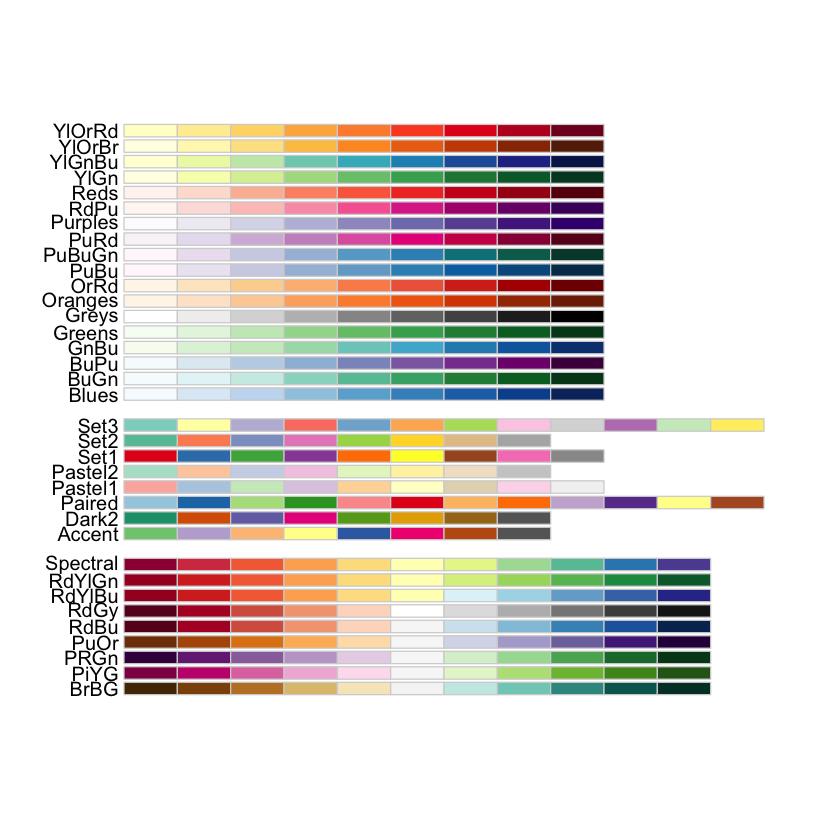

In [34]:
display.brewer.all()

agg_record_2058479759 
                    2

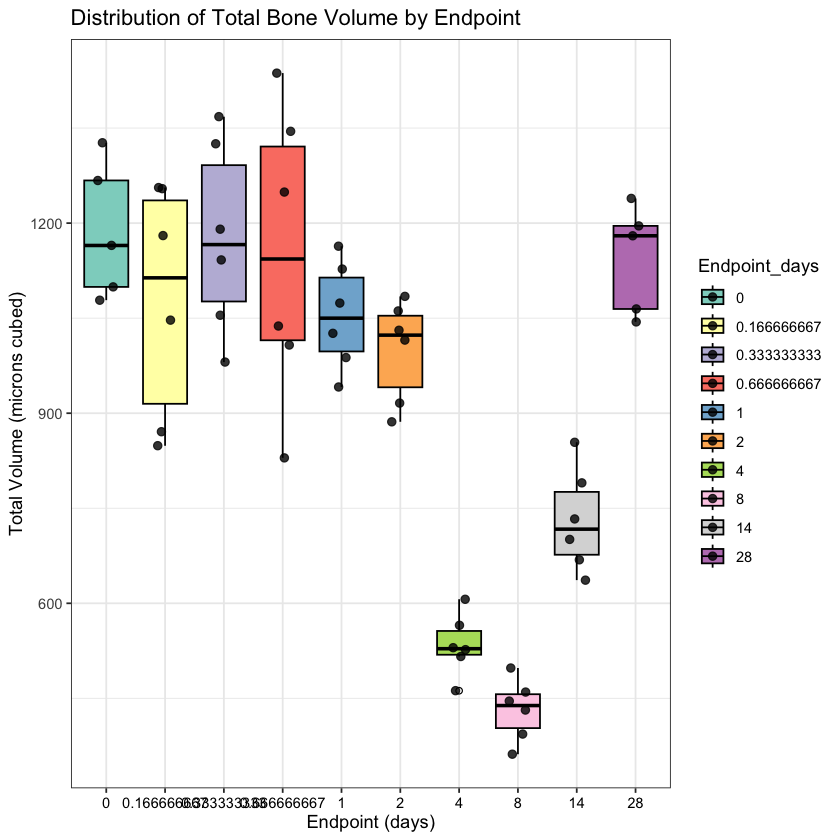

In [73]:
#box and whisker plot
bone_box_and_whisker_plot = ggplot(data = bone_volume_to_plot3, aes(x = Endpoint_days, y = Total_volume, fill = Endpoint_days)) +
                       geom_boxplot(color = "black", outlier.shape = 21, outlier.fill = "white") +
                       theme_bw() +
                       ylab("Total Volume (microns cubed)") +
                       xlab("Endpoint (days)") +
                       ggtitle("Distribution of Total Bone Volume by Endpoint") +
                       scale_fill_brewer(palette = "Set3") +
                       theme(
                        axis.text.x = element_text(color = "black"))+
                       geom_jitter(width = 0.15, size = 2, alpha = 0.8)
print(bone_box_and_whisker_plot)

# Step 1: Call the pdf command to start the plot
pdf(file = "Total_bone_volume_boxplots.pdf",   # The directory you want to save the file in
    width = 12, # The width of the plot in inches
    height = 12) # The height of the plot in inches
# Step 2: Create the plot with R code
print(bone_box_and_whisker_plot)
# Step 3: Run dev.off() to create the file!
dev.off()

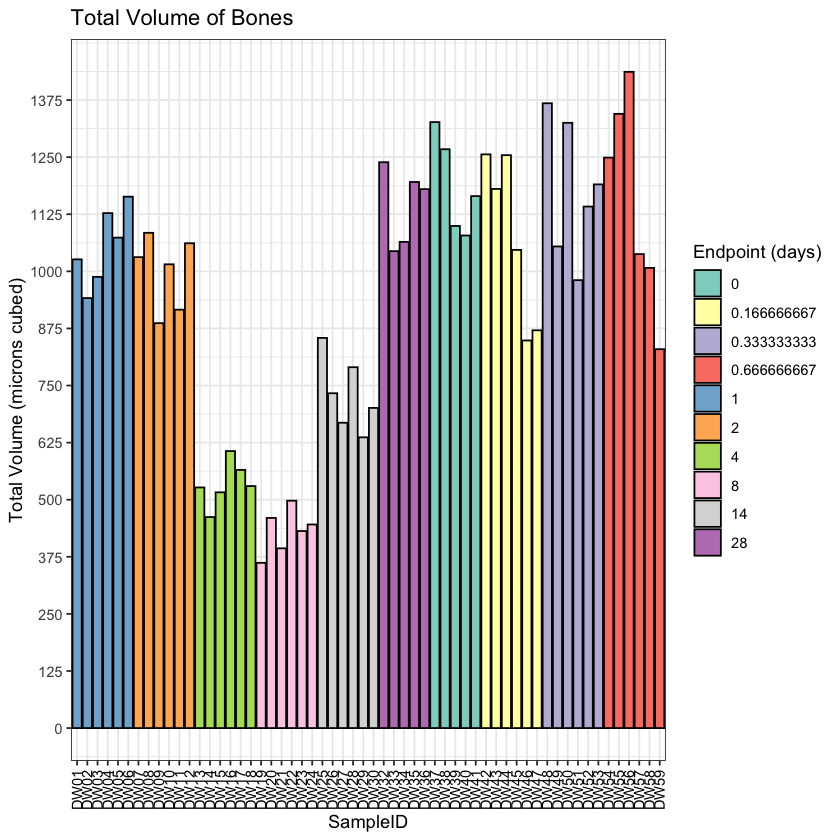

In [41]:
print(bargraph_of_bone_volume)

In [72]:
group_0_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "0"))
print(paste0("Group 0 mean: ", mean(group_0_mean$Total_volume)))

group_1667_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "0.166666667"))
print(paste0("Group 0.16666667 mean: ", mean(group_1667_mean$Total_volume)))

group_3333_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "0.333333333"))
print(paste0("Group 0.333333333 mean: ", mean(group_3333_mean$Total_volume)))

group_6666_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "0.666666667"))
print(paste0("Group 0.666666667 mean: ", mean(group_6666_mean$Total_volume)))

group_1_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "1"))
print(paste0("Group 1 mean: ", mean(group_1_mean$Total_volume)))

group_2_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "2"))
print(paste0("Group 2 mean: ", mean(group_2_mean$Total_volume)))

group_4_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "4"))
print(paste0("Group 4 mean: ", mean(group_4_mean$Total_volume)))

group_8_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "8"))
print(paste0("Group 8 mean: ", mean(group_8_mean$Total_volume)))

group_14_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "14"))
print(paste0("Group 14 mean: ", mean(group_14_mean$Total_volume)))

group_28_mean = data.frame(filter(bone_volume_to_plot3, bone_volume_to_plot3$Endpoint_days == "28"))
print(paste0("Group 28 mean: ", mean(group_28_mean$Total_volume)))

[1] "Group 0 mean: 1187.3168"
[1] "Group 0.16666667 mean: 1076.19216666667"
[1] "Group 0.333333333 mean: 1176.75566666667"
[1] "Group 0.666666667 mean: 1150.91483333333"
[1] "Group 1 mean: 1053.385"
[1] "Group 2 mean: 999.133833333333"
[1] "Group 4 mean: 534.415"
[1] "Group 8 mean: 431.762333333333"
[1] "Group 14 mean: 730.572166666667"
[1] "Group 28 mean: 1144.6478"


In [42]:
bone_volume_to_plot3

SampleID,Total_volume,Endpoint_days
<chr>,<dbl>,<fct>
DW01,1026.218,1
DW02,941.455,1
DW03,987.888,1
DW04,1127.488,1
DW05,1073.762,1
DW06,1163.499,1
DW07,1031.039,2
DW08,1084.356,2
DW09,886.470,2
